In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [5]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/07/29 14:08:53 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/29 14:08:53 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/ubuntu/mlops-training/02-experiment_tracking/mlruns/2', creation_time=1753780599458, experiment_id='2', last_update_time=1753780599458, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet",engine="pyarrow")

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.827368941909368

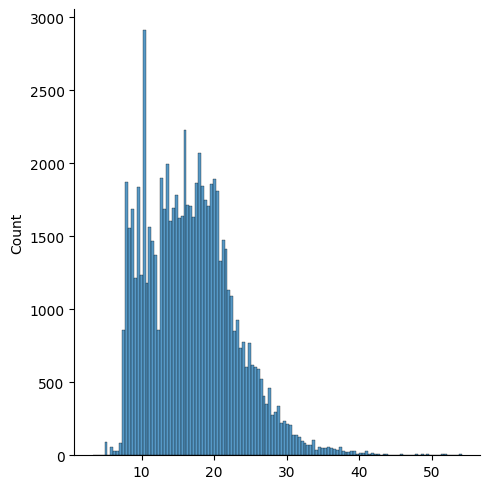

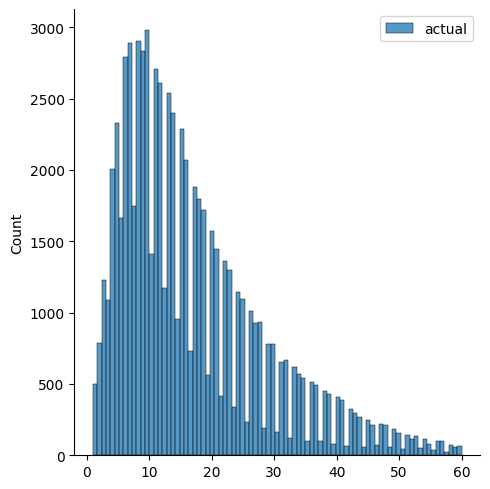

In [8]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    df = pd.read_parquet(filename, engine="pyarrow")

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.7587152133919135

In [16]:
import os
import pickle

# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save model and vectorizer
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():
    mlflow.set_tag("developer", "bro")
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("test-data-path",'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [18]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [23]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
        # mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle/")
        mlflow.xgboost.log_model(booster, path="models_mlflow")
    return {'loss':rmse, 'status':STATUS_OK}

In [34]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4,100,1)),
    'learning_rate': hp.loguniform('learning_rate', -3,0),
    'reg_alpha': hp.loguniform('reg_alpha', -5,-1),
    'reg_lambda': hp.loguniform('reg_lambda', -6,-1),
    'min_child_weight': hp.loguniform('min_child_weight', -1,3),
    'objective': 'reg:squarederror',
    'seed':42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:11.54768                          
[1]	validation-rmse:10.95473                          
[2]	validation-rmse:10.42794                          
[3]	validation-rmse:9.96081                           
[4]	validation-rmse:9.54827                           
[5]	validation-rmse:9.18521                           
[6]	validation-rmse:8.86605                           
[7]	validation-rmse:8.58674                           
[8]	validation-rmse:8.34232                           
[9]	validation-rmse:8.12908                           
[10]	validation-rmse:7.94361                          
[11]	validation-rmse:7.78167                          
[12]	validation-rmse:7.64065                          
[13]	validation-rmse:7.51844                          
[14]	validation-rmse:7.41264                          
[15]	validation-rmse:7.32076                          
[16]	validation-rmse:7.24108                          
[17]	validation-rmse:7.17187                          
[18]	valid

KeyboardInterrupt: 

In [ ]:
#Other method to log on mlflow using one of the predetrmined frameworks
params = {
    'learning_rate': 0.06431075452279457,
    'max_depth': 45,
    'min_child_weight': 3.9809358849019483,
    'objective': 'reg:squarederror',
    'reg_alpha': 0.021831790170560292,
    'reg_lambda': 0.008839071537844754,
    'seed': 42
}

mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round = 1000,
    evals=[(valid,'validation')],
    early_stopping_rounds=50
)

2025/07/29 14:09:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7cd5acfe20ae42dcab48c693f55ea00b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:11.69051
[1]	validation-rmse:11.21098
[2]	validation-rmse:10.77173
[3]	validation-rmse:10.37017
[4]	validation-rmse:10.00356
[5]	validation-rmse:9.66915
[6]	validation-rmse:9.36509
[7]	validation-rmse:9.08879
[8]	validation-rmse:8.83842
[9]	validation-rmse:8.61100
[10]	validation-rmse:8.40505
[11]	validation-rmse:8.21901
[12]	validation-rmse:8.05184
[13]	validation-rmse:7.90069
[14]	validation-rmse:7.76454
[15]	validation-rmse:7.64242
[16]	validation-rmse:7.53171
[17]	validation-rmse:7.43251
[18]	validation-rmse:7.34336
[19]	validation-rmse:7.26286
[20]	validation-rmse:7.19118
[21]	validation-rmse:7.12639
[22]	validation-rmse:7.06838
[23]	validation-rmse:7.01605
[24]	validation-rmse:6.96869
[25]	validation-rmse:6.92643
[26]	validation-rmse:6.88773
[27]	validation-rmse:6.85362
[28]	validation-rmse:6.82229
[29]	validation-rmse:6.79441
[30]	validation-rmse:6.76867
[31]	validation-rmse:6.74508
[32]	validation-rmse:6.72390
[33]	validation-rmse:6.70484
[34]	validation-rms

2025/07/29 14:11:07 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/07/29 14:11:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/29 14:11:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/mlops-training/lib/python3.13/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [14:11:08] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/07/29 14:11:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
